# Unit 5 - Financial Planning

In [91]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import pandas_montecarlo

%matplotlib inline

In [92]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [93]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [94]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [95]:
# Fetch current BTC price
response1 = requests.get(btc_url)
data1 = response1.json()
btc_price = data1["data"]["1"]["quotes"]["USD"]["price"]

# Fetch current ETH price
response2 = requests.get(eth_url)
data2 = response2.json()
eth_price = data2["data"]["1027"]["quotes"]["USD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $25678.80
The current value of your 5.3 ETH is $7175.83


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [96]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [97]:
# Set Alpaca API key and secret
alpaca_apikey = os.getenv("ALPACA_APIKEY")
alpaca_secretkey = os.getenv("ALPACA_SECRETKEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_apikey,
    alpaca_secretkey,
    api_version="v2")

In [98]:
# Format current date as ISO format
today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe, 
    start = today,
    end = today 
).df


# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio["symbol"]== "AGG"].drop("symbol", axis = 1)
SPY = df_portfolio[df_portfolio["symbol"]== "SPY"].drop("symbol", axis = 1)


# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

# Preview DataFrame
df_portfolio

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2020-07-14 04:00:00+00:00  118.58  118.74  118.58  118.67  3986773   

                                                      SPY                 \
                          trade_count        vwap    open    high    low   
timestamp                                                                  
2020-07-14 04:00:00+00:00       14581  118.667215  313.25  319.76  312.0   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2020-07-14 04:00:00+00:00  318.92  93545660      580271  316.244144

In [99]:
# Pick AGG and SPY close prices
agg_close_price = pd.DataFrame()
spy_close_price = pd.DataFrame()
agg_close_price["AGG"] = df_portfolio["AGG"]["close"]
spy_close_price["SPY"] = df_portfolio["SPY"]["close"]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $                              AGG
timestamp                        
2020-07-14 04:00:00+00:00  118.67
Current SPY closing price: $                              SPY
timestamp                        
2020-07-14 04:00:00+00:00  318.92


In [100]:
spy_close_price['SPY'].iloc[0]

318.92

In [101]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price['AGG'].iloc[0]
my_spy_value = my_spy * spy_close_price['SPY'].iloc[0]

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $15946.00
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [102]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value

# Create savings DataFrame
df_savings = pd.DataFrame(
    [
        {
            "type": "crypto", 
            "value": crypto,
        },
        {
            "type": "shares",
            "value": shares,
        },
    ]
).set_index('type')

# Display savings DataFrame
display(df_savings)

,value
type,
crypto,32854.629
shares,39680.000


array([<AxesSubplot:ylabel='value'>], dtype=object)

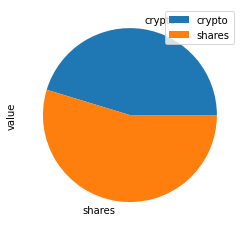

In [103]:
# Plot savings pie chart
plot = df_savings.plot.pie(subplots='True')
plot

In [109]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = crypto + shares

# Validate saving health
if savings >= emergency_fund: 
    print(f"Congratulations! You have enough money in your emergency fund.")
else: 
    print(f"I'm sorry, you do not have enough money in your emergency fund.")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [30]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [62]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe, 
    start = start_date,
    end = end_date 
).df


# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data["symbol"]== "SPY"].drop("symbol", axis = 1)
AGG = df_stock_data[df_stock_data["symbol"]== "AGG"].drop("symbol", axis = 1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])

# Display sample data
df_stock_data.head()

SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2016-05-02 04:00:00+00:00  206.90  208.18  206.41  208.03   61908515   
2016-05-03 04:00:00+00:00  206.50  206.80  205.28  206.13  106422142   
2016-05-04 04:00:00+00:00  205.00  205.85  204.42  204.96   92199810   
2016-05-05 04:00:00+00:00  205.57  205.98  204.47  204.95   67597222   
2016-05-06 04:00:00+00:00  204.04  205.77  203.88  205.70   89131004   

                                                      AGG                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2016-05-02 04:00:00+00:00      263580  207.294812  110.74  110.7400  110.5200   
2016-05-03 04:00:00+00:00      377518  206.312060  110.89  110.9450  110.7500   
2016-05-04 04:00:00+00:00      345261  205.090172  110.91  110.9315  110.7595   
2016-05-05 04:00:00+00:00      280622  205.141555  110.92  111.1600  110.8010   
2016-05-06 04:00:00+00:00      340335  204.937074  111.12  111.1200  110.9700   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2016-05-02 04:00:00+00:00  110.61  3553939       15119  110.627199  
2016-05-03 04:00:00+00:00  110.81  3044940       15662  110.865995  
2016-05-04 04:00:00+00:00  110.86  2920608       13982  110.879063  
2016-05-05 04:00:00+00:00  111.14  3008142       15707  111.028363  
2016-05-06 04:00:00+00:00  110.97  2718710       12697  111.031967

In [75]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(portfolio_data=df_stock_data, 
             weights=[0.6,0.4],
            num_simulation=500,
            num_trading_days=252*30)

## Comment to grader - the instructons for this homework asked us to use 500 as the number of samples. 
#I get performance errors when I do this, but I am still able to produce a result. 
# If I set the number of samples to a lower value there are no issues. 

In [76]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.head()

SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2016-05-02 04:00:00+00:00  206.90  208.18  206.41  208.03   61908515   
2016-05-03 04:00:00+00:00  206.50  206.80  205.28  206.13  106422142   
2016-05-04 04:00:00+00:00  205.00  205.85  204.42  204.96   92199810   
2016-05-05 04:00:00+00:00  205.57  205.98  204.47  204.95   67597222   
2016-05-06 04:00:00+00:00  204.04  205.77  203.88  205.70   89131004   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00      263580  207.294812          NaN  110.74   
2016-05-03 04:00:00+00:00      377518  206.312060    -0.009133  110.89   
2016-05-04 04:00:00+00:00      345261  205.090172    -0.005676  110.91   
2016-05-05 04:00:00+00:00      280622  205.141555    -0.000049  110.92   
2016-05-06 04:00:00+00:00      340335  204.937074     0.003659  111.12   

                                                                            \
                               high       low   close   volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.7400  110.5200  110.61  3553939       15119   
2016-05-03 04:00:00+00:00  110.9450  110.7500  110.81  3044940       15662   
2016-05-04 04:00:00+00:00  110.9315  110.7595  110.86  2920608       13982   
2016-05-05 04:00:00+00:00  111.1600  110.8010  111.14  3008142       15707   
2016-05-06 04:00:00+00:00  111.1200  110.9700  110.97  2718710       12697   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  110.627199          NaN  
2016-05-03 04:00:00+00:00  110.865995     0.001808  
2016-05-04 04:00:00+00:00  110.879063     0.000451  
2016-05-05 04:00:00+00:00  111.028363     0.002526  
2016-05-06 04:00:00+00:00  111.031967    -0.001530

In [77]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 110.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 120.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 130.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 140.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 150.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 160.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 170.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 180.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 190.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 200.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 210.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 220.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 230.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 240.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 250.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 260.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 270.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 280.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 290.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 300.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 310.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 320.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 330.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 340.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 350.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 360.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 370.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 380.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 390.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 400.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 410.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 420.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 430.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 440.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 450.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 460.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 470.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 480.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 490.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009997,0.998480,1.006621,0.992772,1.003711,0.999774,1.000031,1.008460,0.998056,0.996381,...,1.003357,0.998690,0.997591,1.006511,0.979092,0.992898,0.999016,0.998555,1.012083,0.994217
2,1.019717,0.997685,1.004068,0.988299,0.999822,0.991655,1.000331,1.013135,1.006768,0.984126,...,1.000045,0.980360,0.998153,1.012853,0.967876,0.988030,1.002163,0.991998,1.007935,0.993740
3,1.022732,0.994162,1.007774,0.980752,1.000934,0.991618,1.007571,1.018608,1.005556,0.995426,...,0.996979,0.981632,0.988389,0.997594,0.966757,0.995134,0.997174,0.986430,1.005273,0.996032
4,1.018403,0.994654,0.994895,0.972214,0.995250,0.991912,1.014877,1.012760,1.002833,0.994019,...,1.001345,0.981149,0.982816,1.004354,0.946205,0.997606,1.003767,0.987483,0.996786,0.987281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.837784,18.220305,8.499941,22.556267,41.345138,10.774906,12.577144,16.765816,38.324819,21.165006,...,7.952137,9.751184,20.048099,9.714914,35.075464,13.616963,17.812926,13.842092,14.431624,22.426976
7557,8.835417,18.115032,8.557896,22.646470,41.451277,10.904790,12.585882,16.738877,38.257950,21.235334,...,7.972017,9.661475,20.285852,9.623232,35.176388,13.612114,17.737288,13.752231,14.279996,22.391974
7558,8.793783,18.119215,8.684601,22.433139,41.430341,10.831847,12.672153,16.881139,38.428499,21.388092,...,7.921430,9.593828,20.315807,9.610386,35.479421,13.511944,17.725842,13.721322,14.278309,22.561220
7559,8.819768,18.121126,8.589849,22.569482,41.614573,10.802896,12.738058,16.949688,38.482642,21.522318,...,7.883934,9.578191,20.501579,9.662943,35.497101,13.343661,17.855932,13.803101,14.279846,22.628014


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

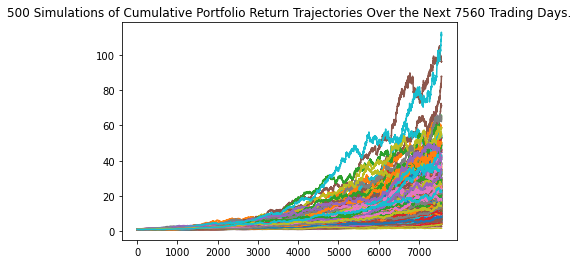

In [78]:
# Plot simulation outcomes
MC_thirtyyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

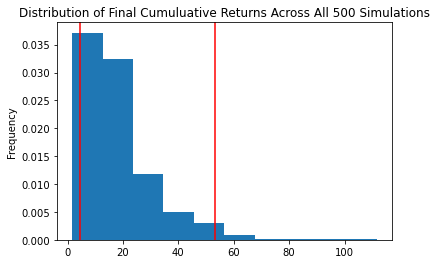

In [79]:
# Plot probability distribution and confidence intervals
MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [74]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
# YOUR CODE HERE!

/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


count           10.000000
mean            14.498563
std              5.893125
min              6.887310
25%             10.260318
50%             13.005490
75%             19.199232
max             24.053633
95% CI Lower     7.421143
95% CI Upper    23.551048
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_upper 
ci_lower

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $95594.94 and $1281072.08


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_upper 
ci_lower

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $143392.41 and $1921608.12


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001799,1.000245,1.006243,0.995742,1.003219,0.998395,0.997985,1.004253,1.002497,0.998947,...,1.007121,1.004291,1.000334,1.000876,0.998973,1.001375,0.996477,1.002103,1.005063,0.995521
2,0.998289,1.000243,1.004284,0.996554,1.004502,0.993317,0.996037,1.010316,1.000850,0.996382,...,1.007016,1.003709,0.999542,1.001450,1.004142,1.004022,0.996702,1.004359,1.009205,0.999000
3,1.002639,0.997279,1.008339,0.992870,0.998657,0.989041,0.994189,1.010062,0.999200,0.999132,...,1.004156,1.002288,1.003976,0.994908,1.008989,1.004545,0.995074,1.010488,1.011124,1.002626
4,1.008853,0.996292,1.002813,0.995244,0.996794,0.990576,0.999322,1.010897,0.989222,0.995257,...,1.000057,1.007349,1.006909,0.990823,1.013085,1.002427,0.996293,1.007081,1.010369,0.998654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.438618,0.926659,1.048662,1.101424,1.134443,1.200987,1.347489,1.257520,1.428939,1.194429,...,1.104654,1.273680,1.276718,1.297344,1.229379,1.295593,1.501864,1.198438,1.386161,1.426163
1257,1.441785,0.926428,1.048574,1.104941,1.137374,1.204559,1.360843,1.260661,1.429710,1.201055,...,1.107447,1.269262,1.265880,1.296800,1.227049,1.297884,1.510874,1.190802,1.388448,1.427391
1258,1.444675,0.931714,1.053040,1.110206,1.140592,1.199869,1.358605,1.254728,1.426409,1.207420,...,1.101690,1.274683,1.281527,1.303255,1.227517,1.294870,1.503567,1.191945,1.388434,1.441467
1259,1.443488,0.934065,1.049921,1.108998,1.142538,1.203844,1.363563,1.254192,1.425030,1.213366,...,1.103902,1.276629,1.275813,1.296929,1.222773,1.285521,1.498580,1.192940,1.397786,1.440244


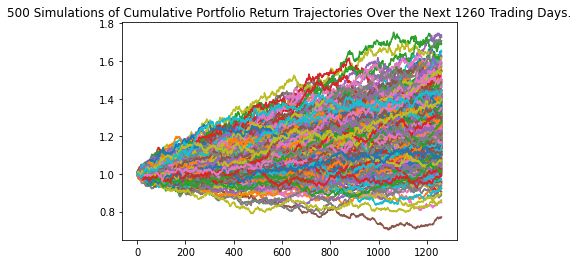

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

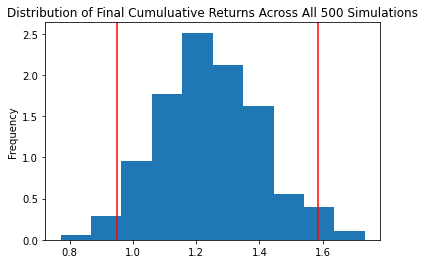

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.245905
std               0.160008
min               0.771559
25%               1.140795
50%               1.232555
75%               1.352284
max               1.733421
95% CI Lower      0.951523
95% CI Upper      1.586592
Name: 1260, dtype: float64


In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57091.37 and $95195.55


### Ten Years Retirement Option

In [86]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(portfolio_data=df_stock_data, 
             weights=[0.6,0.4],
            num_simulation=500,
            num_trading_days=252*10)

In [87]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 110.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 120.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 130.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 140.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 150.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 160.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 170.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 180.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 190.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 200.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 210.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 220.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 230.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 240.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 250.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 260.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 270.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 280.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 290.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 300.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 310.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 320.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 330.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 340.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 350.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 360.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 370.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 380.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 390.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 400.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 410.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 420.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 430.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 440.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 450.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 460.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 470.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 480.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

Running Monte Carlo simulation number 490.


/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTool

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998867,0.977599,1.009121,0.996675,0.994494,1.013524,1.001374,0.990698,1.002566,0.994009,...,1.011251,0.986940,0.997158,0.999666,0.998905,1.001086,0.998053,0.998667,1.013416,0.992027
2,0.992496,0.988121,1.007430,1.000067,0.985682,1.003478,0.986841,0.990962,1.001914,0.986489,...,1.011065,0.995606,1.012714,0.997987,1.013987,0.994034,0.992526,1.004871,1.025193,1.001473
3,0.995195,0.981560,1.012679,0.999637,0.994367,1.012070,0.999583,0.985415,0.999157,0.983779,...,1.015057,1.000485,1.001601,0.997220,1.019031,0.987025,0.992261,1.000058,1.019000,1.003227
4,0.994938,0.994496,1.013912,1.010766,1.004491,1.007967,0.991981,0.986029,1.006013,0.990768,...,1.005562,0.998657,0.997354,1.000188,1.025626,0.980559,0.986017,0.990331,1.004508,1.011521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.885350,1.693656,3.777976,2.852881,1.972220,1.621406,2.539550,2.672010,2.512810,3.491883,...,2.514986,2.884821,1.407511,1.782897,1.405668,1.308671,2.073048,2.819733,2.313105,1.272642
2517,3.883403,1.681560,3.790925,2.858750,1.963149,1.619588,2.508981,2.692412,2.542017,3.515541,...,2.532882,2.881955,1.414149,1.782676,1.391877,1.315994,2.065479,2.825335,2.318726,1.292151
2518,3.852834,1.665018,3.771458,2.900180,1.976738,1.624019,2.516796,2.671705,2.581356,3.441580,...,2.490995,2.924372,1.426298,1.786780,1.394328,1.304030,2.042646,2.813421,2.303006,1.289862
2519,3.897403,1.667348,3.748769,2.892683,1.946182,1.626507,2.514881,2.671004,2.599035,3.442354,...,2.490980,2.922957,1.443979,1.784292,1.403436,1.304381,2.045812,2.832714,2.297744,1.287216


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

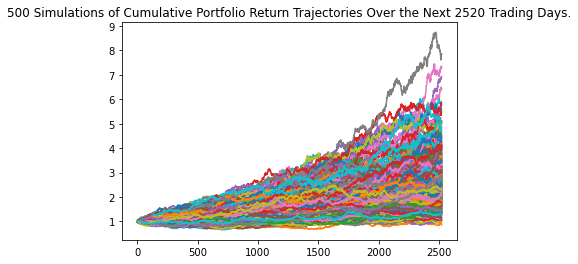

In [88]:
# Plot simulation outcomes
MC_tenyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

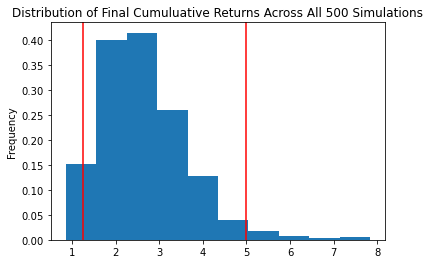

In [89]:
# Plot probability distribution and confidence intervals
MC_tenyear.plot_distribution()

In [90]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_tenyear.summarize_cumulative_return()

# Print summary statistics
# YOUR CODE HERE!

/Users/cynthiadavis/Documents/GitHub/Module_5_Challenge/Instructions/Starter_Code/MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


count           500.000000
mean              2.653413
std               0.989472
min               0.855785
25%               1.955010
50%               2.530263
75%               3.150961
max               7.836066
95% CI Lower      1.253561
95% CI Upper      4.986695
Name: 2520, dtype: float64

In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
